# Lanczos and Power method for approximating extremal eigenvalues

In this notebook, we're going to be building our own Lanczos and power method solvers. We'll be studying the Hubbard model on a $3\times 3$ triangular cell, at and with $1/3$ doping and $S^z=0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
from lattice2D import Lattice2D
from more_itertools import distinct_permutations
from scipy.special import binom
from scipy import sparse
plt.rcParams['figure.dpi'] = 300
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

## 1. Defining the lattice 
We'll use a $3 \times 3$ square with primitive lattice vectors $\vec a_1 = \vec u_x$ and $\vec a_2 = \vec u_y$. The supercell lattive vectors are $\vec A_1 = 3 \vec a_1$ and $\vec A_2 = 3 \vec a_2$. Do do this, we'll use the Python package ```lattice2D```.

In [2]:
primitive_lattice_vectors = np.array([[1,0], [0,1]])
atom_coords = np.array([[0,0]])
supercell_coefficients = np.array([3,0,0,3])
triangular_lattice = Lattice2D(primitive_lattice_vectors, atom_coords, supercell_coefficients)

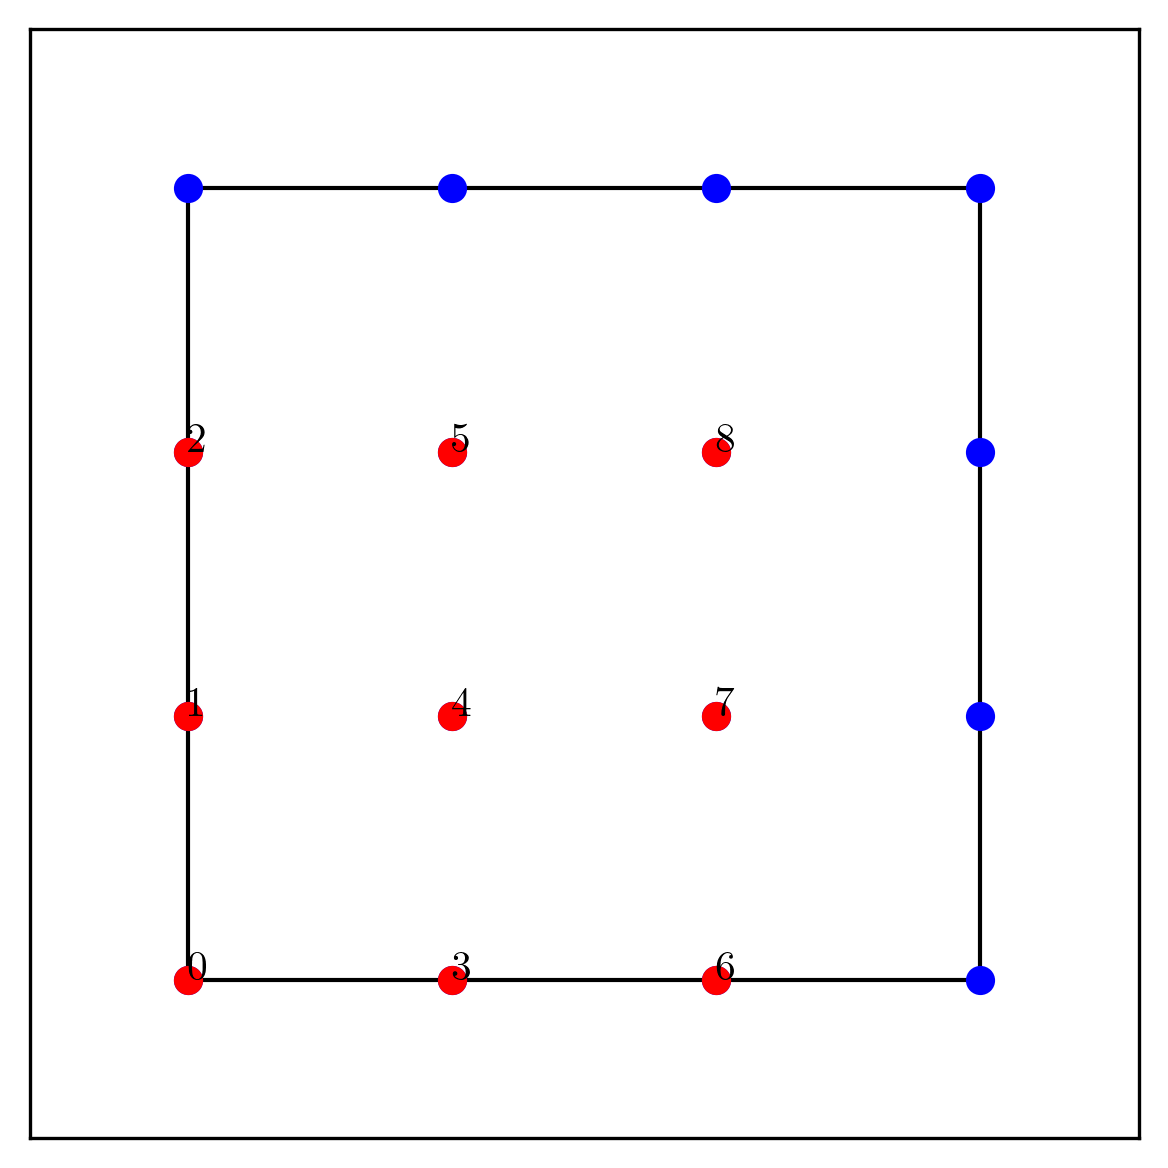

In [3]:
triangular_lattice.plot_supercell()

## 2. Defining the Hilbert space
We'll need to store the basis states particle number conservation and $S^z$ symmetry. We have $M=9.$ We have $N_\uparrow = N_\downarrow = 3$. This should give a total dimension of $d= \binom{M}{N_\uparrow} \times \binom{M}{N_\downarrow}= 7056.$ To generate and store the basis, we define two shuffle arrays containing $3$ ones and $6$ zeros. Then, we generate all the distinct permutations of these arrays, this gives us the spin down sector and the spin up sectors. Finally, for each $\uparrow$ and $\downarrow$ combination, we concatenate the arrays to get an array of size $2M$ where the first $M$ entries are the $\uparrow$ occupations and the last $M$ entries are the $\downarrow$ occupations. We store each number as an integer: $n = 2^M n_\uparrow + n_\downarrow$ and construct a hash table where each integer is mapped to a unique number between $0$ and $d-1$.

In [4]:
nup = ndown = 3
M=9
shuffle_array_up = np.array([1]*nup + [0]*(M-nup))
shuffle_array_down = np.array([1]*ndown + [0]*(M-ndown))


In [5]:
up_basis = np.array(list(distinct_permutations(shuffle_array_up)), dtype= np.byte)
down_basis = np.array(list(distinct_permutations(shuffle_array_down)), dtype = np.byte)

In [6]:
counter = 0
dim = int(binom(M,nup)*binom(M,ndown))
basis = {}
for up in up_basis:
    for down in down_basis:
        basis_state = np.concatenate((up, down))
        basis_state_int = int(''.join(map(str, basis_state)), 2)
        basis[basis_state_int] = counter
        counter += 1

dim = counter
dim

7056

## Functions for implementing the Hamiltonian
Let's define the functions that act on our basis bit strings and implement the Hubbard Hamiltonian: 

$$\mathcal{\hat H} = -t\sum_{\langle ij\rangle, \sigma} \hat c_{i\sigma}^\dag c_{j\sigma} + \hat c_{j\sigma}^\dag \hat c_{i\sigma}+ U\sum_i \hat n_{i\uparrow} \hat n_{i\downarrow}.$$

In [7]:
def n(N,i,spin,M):
    """returns the eigenvalue for the number operator for spin sigma on site i
    either 0 or 1."""

    return (N>>(i+M*spin))&1


def phase(N,i,j,spin,M):
    """returns the phase for the creation operator c^dagger_i c_j +/-1"""

    parity = sum([(N>>(l+M*spin))&1 for l in range(min(i,j)+1,max(i,j))])%2
    return (-1)**parity


def checkcdagc(N,i,j,spin,M):
    """returns True if the hopping is possible, False otherwise"""

    if n(N,j,spin,M) - n(N,i,spin,M) ==1:
        return True
    else:
        return False


def cdagc(N,i,j,spin,M):
    """Returns a new state with a particle created on site i and destroyed on site j as well as the phase, 
    assumes that check is True."""

    p = phase(N,i,j,spin,M)
    mask = (1<<(i+M*spin)) | (1<<(j+M*spin))
    N = N^mask
    return p, N

## 3. Constructing the Hamiltonian
We will store the Hamiltonian as a sparse matrix. To do this, we create 3 lists for the rows, columns and values. Then, we loop through elements of the basis and apply the operators to the basis states. Each time we find a matrix element, we store the indicies in the rows and columns list and the corresponding value in the value list. 

In [8]:
#first, get the pairs of distinct first neighbors
first_neighbor_pairs = []
D = triangular_lattice.distance_matrix()
for i in range(M):
    for j in range(i+1,M):
        if D[i,j] == 1:
            first_neighbor_pairs.append((i,j))


print(first_neighbor_pairs)
print(4*M/2)
print(len(first_neighbor_pairs))

[(0, 1), (0, 2), (0, 3), (0, 6), (1, 2), (1, 4), (1, 7), (2, 5), (2, 8), (3, 4), (3, 5), (3, 6), (4, 5), (4, 7), (5, 8), (6, 7), (6, 8), (7, 8)]
18.0
18


In [9]:
rows, cols, vals, vals_shifted = [], [], [], []
U = 1.0
spectral_shift = 12.0

for state, column in basis.items():

    diagonal_element = 0.0
    for i in range(M):

        diagonal_element += U*n(state,i,0,M)*n(state,i,1,M)

    rows.append(column)
    cols.append(column)
    vals.append(diagonal_element)
    vals_shifted.append(diagonal_element-spectral_shift)

    for i,j in first_neighbor_pairs:

        if checkcdagc(state,i,j,0,M):

            p, new_state = cdagc(state,i,j,0,M)
            row = basis[new_state]
            rows.append(row)
            cols.append(column)
            vals.append(-p)
            vals_shifted.append(-p)

        if checkcdagc(state,i,j,1,M):

            p, new_state = cdagc(state,i,j,1,M)
            row = basis[new_state]
            rows.append(row)
            cols.append(column)
            vals.append(-p)
            vals_shifted.append(-p)


        
        if checkcdagc(state,j,i,0,M):

            p, new_state = cdagc(state,j,i,0,M)
            row = basis[new_state]
            rows.append(row)
            cols.append(column)
            vals.append(-p)
            vals_shifted.append(-p)

        if checkcdagc(state,j,i,1,M):

            p, new_state = cdagc(state,j,i,1,M)
            row = basis[new_state]
            rows.append(row)
            cols.append(column)
            vals.append(-p)
            vals_shifted.append(-p)

    

        

## 4. Finding the ground state 
### Full diagonalization
We can still find the full spectrum of the matrix here, so let's find the ground state energy and use it as a benchmark.

In [10]:
H = sparse.csr_matrix((vals, (rows, cols)), shape=(dim, dim)).toarray()
E0_exact = np.linalg.eigvalsh(H)[0]

### Power method
Let's find the ground state using the power method.
Let's make a Python class that implements the following: 

* Start with a random normalized vector $|\phi_0 \rangle.$
* Then get $|\tilde \phi_{k+1} \rangle = \mathcal{\hat H} |\phi_k\rangle$.
* Then normalize $|\phi_{k+1} \rangle = |\tilde \phi_{k+1} \rangle/|| |\tilde \phi_{k+1} \rangle ||$.

At each step, we calculate the energy $E_0 \approx \langle \phi_k |\mathcal{\hat H} |\phi_k \rangle$ and check if it has converged to some tolerance. 

In [11]:
def sparse_matrix_vector_product(rows,cols,vals, phi):

    """function that computes the matrix vector product of a sparse matrix defined by the rows, cols and vals arrays."""

    result = np.zeros_like(phi)
    for i in range(len(rows)):
        result[rows[i]] += vals[i]*phi[cols[i]]
    return result


def energy_expect(rows,cols,vals,phi): 
    
    """Function that computes the expectation value of the energy for a given state phi."""

    Hphi = sparse_matrix_vector_product(rows,cols,vals, phi)
    E = phi.dot(Hphi)
    return E


class PowerMethod:

    def __init__(self, rows, cols, vals, vals_shifted, phi, max_iter=1000, tol=1e-4):
        self.rows = rows
        self.cols = cols
        self.vals = vals
        self.vals_shifted = vals_shifted
        self.phi = phi
        self.max_iter = max_iter
        self.tol = tol

    def get_energy(self):

        Hphi = sparse_matrix_vector_product(self.rows, self.cols, self.vals_shifted, self.phi)
        self.phi = Hphi/np.linalg.norm(Hphi)
        E = energy_expect(self.rows, self.cols, self.vals, self.phi)

        return E
    

    def solve(self):

        E_previous = np.inf
        converged = False
        iteration_counter = 0
        logger = []

        while iteration_counter < self.max_iter:
            
            
            E_current = self.get_energy()
            if np.abs(E_current- E_previous) < self.tol:

                converged = True

            if converged:
                break

            
            logger.append(E_current)
            E_previous = E_current
            print("Iteration: {}, current energy: {}".format(iteration_counter,E_current))
            iteration_counter += 1

        return E_current, np.array(logger)



In [12]:
phi = np.random.rand(dim)
phi /= np.linalg.norm(phi)

In [13]:
power_solver = PowerMethod(rows, cols, vals,vals_shifted,phi)
E0power, logpower = power_solver.solve()

Iteration: 0, current energy: -6.8283557953670915
Iteration: 1, current energy: -7.790713843378016
Iteration: 2, current energy: -8.447301830486833
Iteration: 3, current energy: -8.961002645405806
Iteration: 4, current energy: -9.381598435532188
Iteration: 5, current energy: -9.729868826048419
Iteration: 6, current energy: -10.017795267227754
Iteration: 7, current energy: -10.254280593514894
Iteration: 8, current energy: -10.446916549889893
Iteration: 9, current energy: -10.60252048853898
Iteration: 10, current energy: -10.727254367757574
Iteration: 11, current energy: -10.826611173232333
Iteration: 12, current energy: -10.905383288012708
Iteration: 13, current energy: -10.967656956116416
Iteration: 14, current energy: -11.016842327109261
Iteration: 15, current energy: -11.055732359401333
Iteration: 16, current energy: -11.086578671499247
Iteration: 17, current energy: -11.111173126887724
Iteration: 18, current energy: -11.130926953533493
Iteration: 19, current energy: -11.146942480883

## Lanczos method 
Let's try using the Lanczos algorithm to see if we can converge to the ground state faster. In the Lanczos algorithm is the following: 

* Start wih a random normalized vector $|\phi_0\rangle$.
* At each step, compute $|\tilde \phi_{k+1} \rangle = \mathcal{\hat H} |\phi_k\rangle - \alpha_k |\phi_k \rangle - \beta_k |\phi_{k-1} \rangle$, where $\alpha_k = \langle \phi_k |\mathcal{\hat H}|\phi_k\rangle$ and $\beta_k = \langle \phi_{k-1} |\mathcal{\hat H}|\phi_k \rangle$. 
* In the Lanczos basis, the Hamiltonian is tri-diagonal. So at each iteration, we add the new matrix elements to our tri-diagonal matrix. 
* Diagonalize the new tri-diagonal matrix and check if the new eigenvalue has converged with the previous one up to some tolerance. 

In [14]:
class Lanczos:

    def __init__(self, rows, cols, vals, phi0, max_iter=1000, tol = 1e-4):

        self.rows = rows
        self.cols = cols
        self.vals = vals
        self.phi0 = phi0
        self.max_iter = max_iter
        self.tol = tol


    def iteration(self, phi_current, phi_previous):

        alpha = phi_current.dot(sparse_matrix_vector_product(self.rows, self.cols, self.vals, phi_current))
        beta = phi_previous.dot(sparse_matrix_vector_product(self.rows, self.cols, self.vals, phi_current))
        phi_next = sparse_matrix_vector_product(self.rows, self.cols, self.vals, phi_current) - alpha*phi_current - beta*phi_previous

        phi_next /= np.linalg.norm(phi_next)

        return alpha, beta, phi_next


    def solve(self):

        phi_current = self.phi0
        phi_previous = np.zeros_like(phi_current)
        E_previous = np.inf
        converged = False
        diag = []
        updiag = []
        logger = []
        iteration_counter = 0

        while iteration_counter < self.max_iter:

            alpha, beta, phi_next = self.iteration(phi_current, phi_previous)
            diag.append(alpha)
            updiag.append(beta)

            if iteration_counter == 0:

                E_current = alpha
                print(E_current)
            else:

                Htri = np.diag(diag) + np.diag(updiag[1:], k=1) + np.diag(updiag[1:], k=-1)
                E_previous = E_current
                E_current = np.linalg.eigvalsh(Htri)[0]
                logger.append(E_current)

                if np.abs(E_current-E_previous) < self.tol:
                    converged = True

                
            if converged:
                break


            phi_previous = phi_current
            phi_current = phi_next
            iteration_counter += 1
            print("Iteration: {}, current energy: {}".format(iteration_counter, E_current))
        return E_current, np.array(logger)



In [15]:
lanczos_solver = Lanczos(rows, cols, vals, phi)
E0lanczos, loglanczos = lanczos_solver.solve()

-4.813359319968548
Iteration: 1, current energy: -4.813359319968548
Iteration: 2, current energy: -7.6558816920965524
Iteration: 3, current energy: -9.229392746408415
Iteration: 4, current energy: -10.24018407873094
Iteration: 5, current energy: -10.800805506904913
Iteration: 6, current energy: -11.075657928580128
Iteration: 7, current energy: -11.157307722365534
Iteration: 8, current energy: -11.181363114241334
Iteration: 9, current energy: -11.208835821625469
Iteration: 10, current energy: -11.264628115455697
Iteration: 11, current energy: -11.293809546079503
Iteration: 12, current energy: -11.324794470423308
Iteration: 13, current energy: -11.338087842725129
Iteration: 14, current energy: -11.348585568047676
Iteration: 15, current energy: -11.358856968078282
Iteration: 16, current energy: -11.382452455607215
Iteration: 17, current energy: -11.40977542275166
Iteration: 18, current energy: -11.417973460512322
Iteration: 19, current energy: -11.421498747846474
Iteration: 20, current en

In [16]:
diffpower, difflanczos = np.abs(logpower-E0_exact), np.abs(loglanczos-E0_exact)

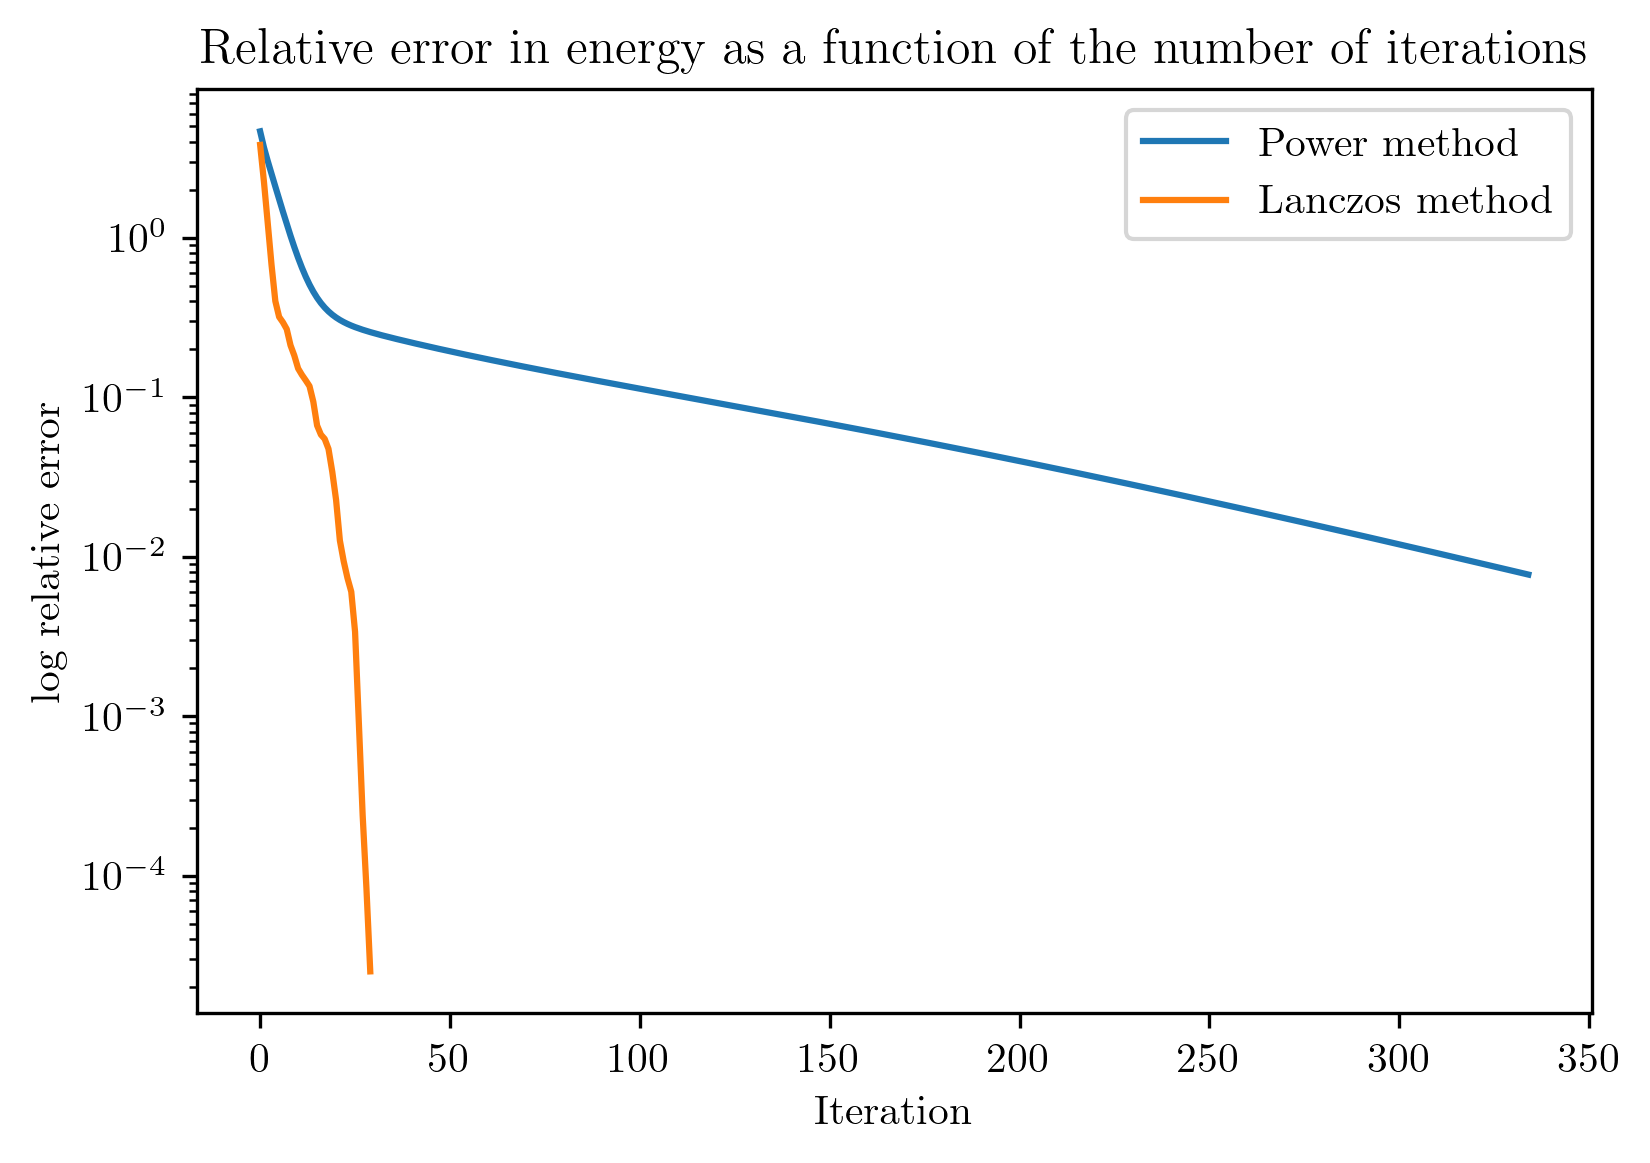

In [28]:
fig, ax = plt.subplots(figsize=(6,4))

ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('log relative error')
ax.plot(diffpower, label='Power method')
ax.plot(difflanczos, label='Lanczos method')
ax.legend()
ax.set_title('Relative error in energy as a function of the number of iterations')

plt.savefig('./figures/powervlanczos.png')